In [1]:
import numpy as np
import cv2 as cv
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
path_tmpl = 'trees/' + 'tree%d.jpg'

# Load images
paths = [path_tmpl % i for i in range(1,13)]
imgs = [cv.imread(path) for path in paths]
imgs = [cv.resize(img, (500, 500), interpolation = cv.INTER_AREA) for img in imgs]

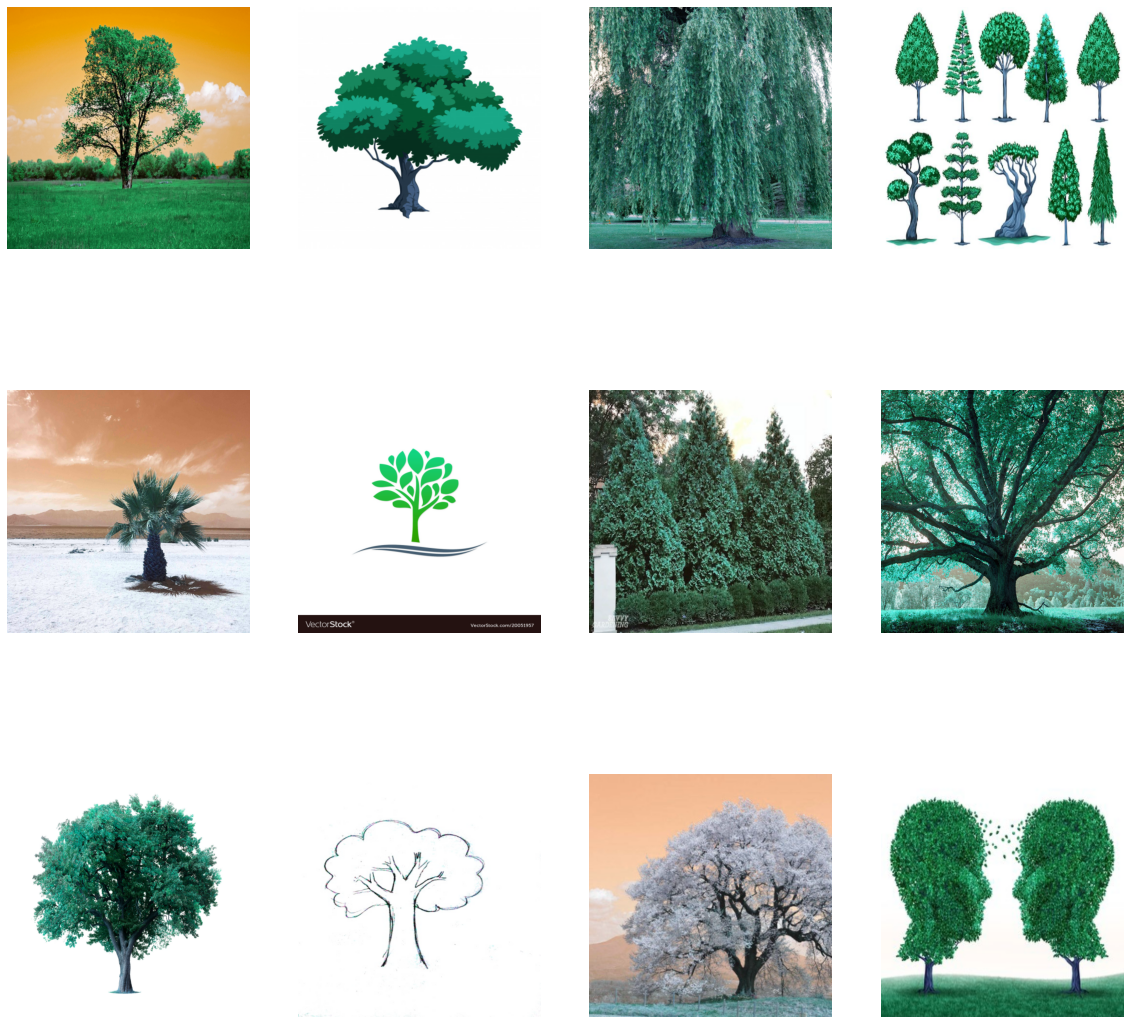

In [3]:
plt.figure(figsize=(20, 20))
for i, img in enumerate(imgs, 1):
    ax = plt.subplot(3, 4, i)
    plt.imshow(img)
    plt.axis("off")

In [4]:
idx = 11

(-0.5, 499.5, 499.5, -0.5)

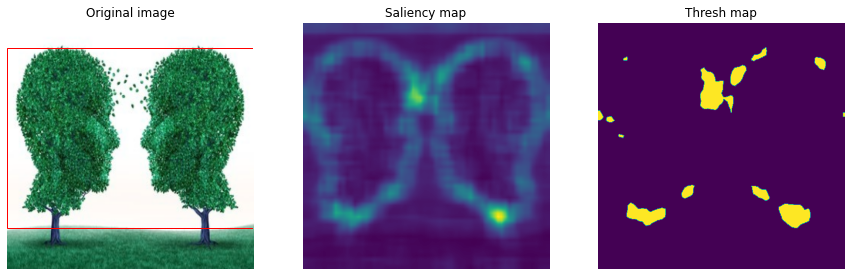

In [5]:
# Compute the saliency map using static saliency spectral residual detector
saliency = cv.saliency.StaticSaliencySpectralResidual_create()
(success, saliencyMap) = saliency.computeSaliency(cv.cvtColor(imgs[idx], cv.COLOR_BGR2GRAY))
saliencyMap = (saliencyMap * 255).astype("uint8")
threshMap = cv.threshold(saliencyMap, 100, 255, cv.THRESH_BINARY)[1]
x,y,w,h = cv.boundingRect(threshMap)
rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')

plt.figure(figsize=(15, 10))
ax = plt.subplot(1, 3, 1)
plt.imshow(imgs[idx])
ax.add_patch(rect)
plt.title("Original image")
plt.axis("off")
ax = plt.subplot(1, 3, 2)
plt.imshow(saliencyMap)
plt.title("Saliency map")
plt.axis("off")
ax = plt.subplot(1, 3, 3)
plt.imshow(threshMap)
plt.title("Thresh map")
plt.axis("off")

(-0.5, 499.5, 499.5, -0.5)

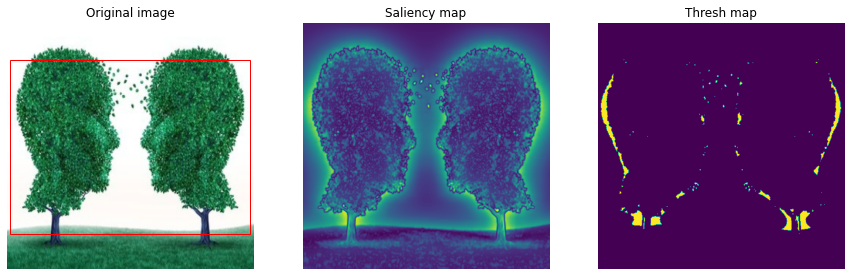

In [6]:
# Compute the saliency map using static fine grained saliency detector
saliency = cv.saliency.StaticSaliencyFineGrained_create()
(success, saliencyMap) = saliency.computeSaliency(cv.cvtColor(imgs[idx], cv.COLOR_BGR2GRAY))
threshMap = cv.threshold(saliencyMap.astype("uint8"), 175, 255, cv.THRESH_BINARY)[1]
x,y,w,h = cv.boundingRect(threshMap)
rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')

plt.figure(figsize=(15, 10))
ax = plt.subplot(1, 3, 1)
plt.imshow(imgs[idx])
ax.add_patch(rect)
plt.title("Original image")
plt.axis("off")
ax = plt.subplot(1, 3, 2)
plt.imshow(saliencyMap)
plt.title("Saliency map")
plt.axis("off")
ax = plt.subplot(1, 3, 3)
plt.imshow(threshMap)
plt.title("Thresh map")
plt.axis("off")

In [7]:
def isCenter(image, x, y, w, h, dist_thresh=100):
    dist_hor = abs((x + w / 2) - (len(image[0]) / 2))
    dist_ver = abs((y + h / 2) - (len(image) / 2))
    dist_from_center = math.sqrt(dist_hor * dist_hor + dist_ver * dist_ver)
    return True if dist_from_center <= dist_thresh else False

def isDominant(image, w, h, area_thresh=4):
    area_img = len(image) * len(image[0])
    area_saliency = w * h
    return True if area_img < area_thresh * area_saliency else False

In [8]:
center = [False for i in range(len(imgs))]
dominance = [False for i in range(len(imgs))]
saliency = cv.saliency.StaticSaliencySpectralResidual_create()
for i, img in enumerate(imgs):
    (success, saliencyMap) = saliency.computeSaliency(cv.cvtColor(img, cv.COLOR_BGR2GRAY))
    saliencyMap = (saliencyMap * 255).astype("uint8")
    threshMap = cv.threshold(saliencyMap, 100, 255, cv.THRESH_BINARY)[1]
    x,y,w,h = cv.boundingRect(threshMap)
    center[i] = isCenter(img, x, y, w, h)
    dominance[i] = isDominant(img, w, h)

In [9]:
center, dominance

([True, True, True, True, False, False, True, True, True, True, False, True],
 [False, True, True, True, False, True, True, True, True, True, True, True])

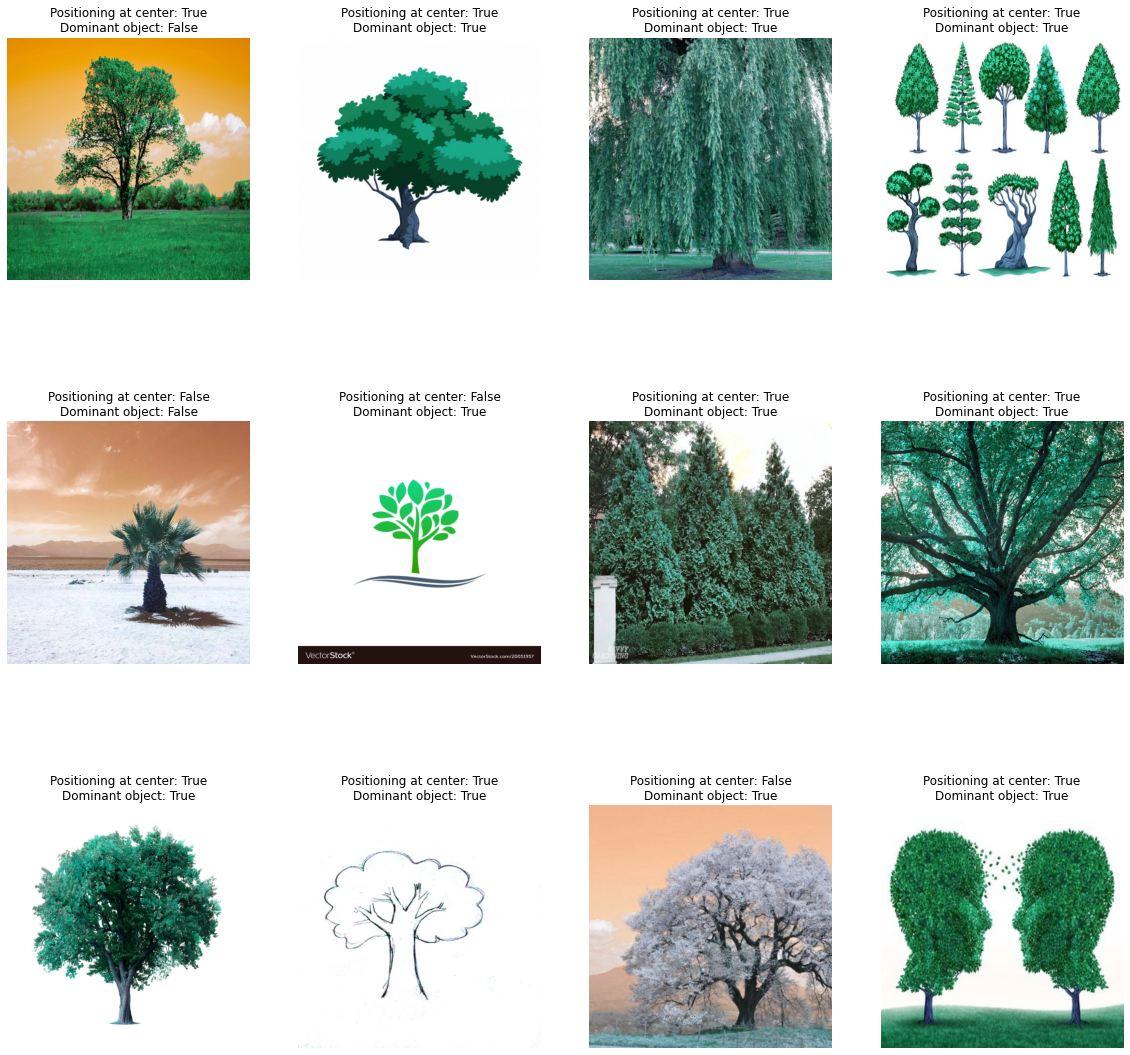

In [10]:
plt.figure(figsize=(20, 20))
for i in range(1, len(imgs) + 1):
    ax = plt.subplot(3, 4, i)
    plt.imshow(imgs[i - 1])
    plt.title("Positioning at center: " + str(center[i - 1]) + "\nDominant object: " + str(dominance[i - 1]))
    plt.axis("off")

In [20]:
center = [False for i in range(len(imgs))]
dominance = [False for i in range(len(imgs))]
saliency = cv.saliency.StaticSaliencyFineGrained_create()
for i, img in enumerate(imgs):
    (success, saliencyMap) = saliency.computeSaliency(cv.cvtColor(img, cv.COLOR_BGR2GRAY))
    threshMap = cv.threshold(saliencyMap, 170, 255, cv.THRESH_BINARY)[1]
    x,y,w,h = cv.boundingRect(threshMap)
    center[i] = isCenter(img, x, y, w, h, dist_thresh=50)
    dominance[i] = isDominant(img, w, h, area_thresh=2.5)

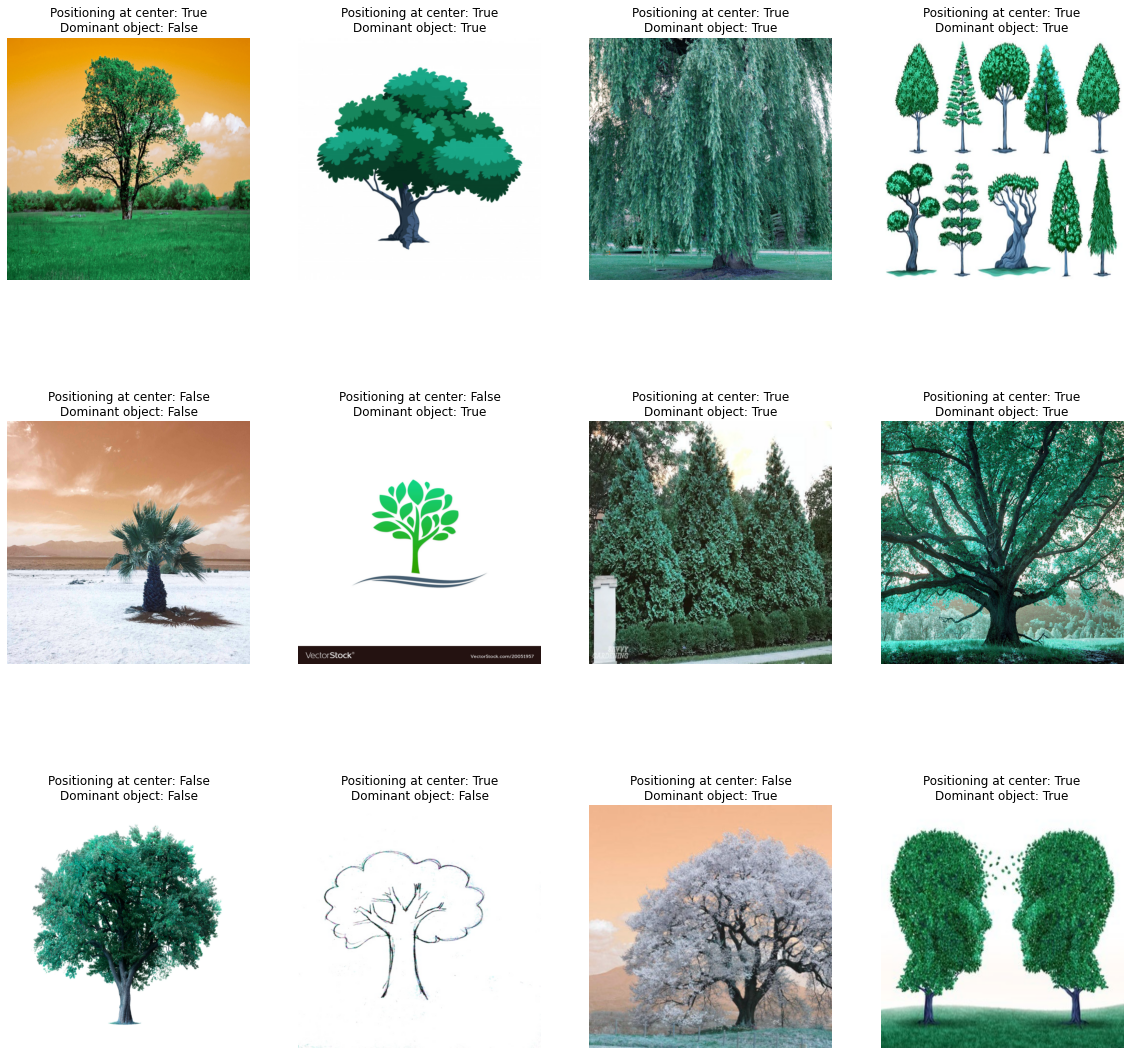

In [21]:
plt.figure(figsize=(20, 20))
for i in range(1, len(imgs) + 1):
    ax = plt.subplot(3, 4, i)
    plt.imshow(imgs[i - 1])
    plt.title("Positioning at center: " + str(center[i - 1]) + "\nDominant object: " + str(dominance[i - 1]))
    plt.axis("off")

In [13]:
idx = 11

(-0.5, 499.5, 499.5, -0.5)

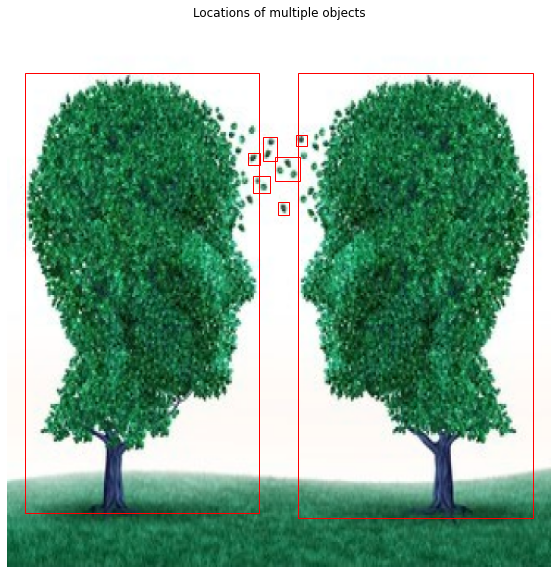

In [19]:
# Detect multiple objects
gray = cv.cvtColor(imgs[idx], cv.COLOR_BGR2GRAY)
blurred = cv.GaussianBlur(gray, (3, 3), 0)
canny = cv.Canny(blurred, 50, 255, 1)
kernel = np.ones((5,5),np.uint8)
dilate = cv.dilate(canny, kernel, iterations=1)

# Find contours
cnts = cv.findContours(dilate, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

# Iterate thorugh contours and filter for ROI
plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1)
plt.imshow(imgs[idx])
for c in cnts:
    x,y,w,h = cv.boundingRect(c)
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.title("Locations of multiple objects")
plt.axis("off")